In [147]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import polars as pl

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix

In [148]:
data = pd.read_csv('dataset/Network_anomaly_data.csv')


data = data.drop(columns=['protocoltype', 'service', 'flag'])

data['attack'] = data['attack'].apply(lambda x: 0 if x == 'normal' else 1)




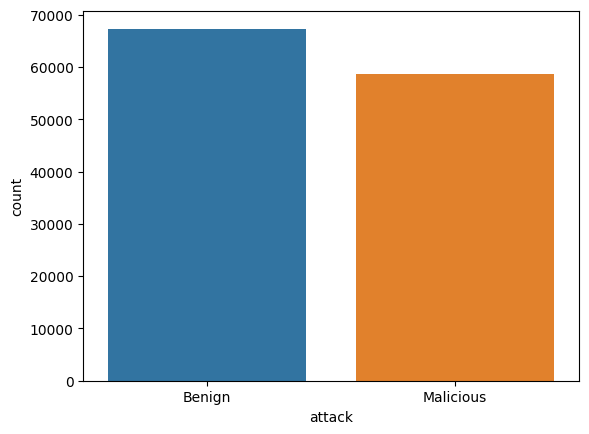

In [149]:
data_anomaly = data[data['attack'] == 1]
data_normal = data[data['attack'] == 0]

df_count = pl.DataFrame({'attack': ['Benign', 'Malicious'], 'count': [data_normal.shape[0], data_anomaly.shape[0]]})
sns.barplot(x='attack', y='count', hue='attack', data=df_count)
plt.show()


In [150]:

target_column = 'attack'  
correlation_threshold = 0.5


correlation_matrix = data.corr()

high_corr_features = correlation_matrix[target_column][correlation_matrix[target_column].abs() > correlation_threshold].index.tolist()

high_corr_features.remove(target_column)


print("Highly correlated features with the target:")
print(high_corr_features)


Highly correlated features with the target:
['loggedin', 'count', 'serrorrate', 'srvserrorrate', 'samesrvrate', 'dsthostsrvcount', 'dsthostsamesrvrate', 'dsthostserrorrate', 'dsthostsrvserrorrate']


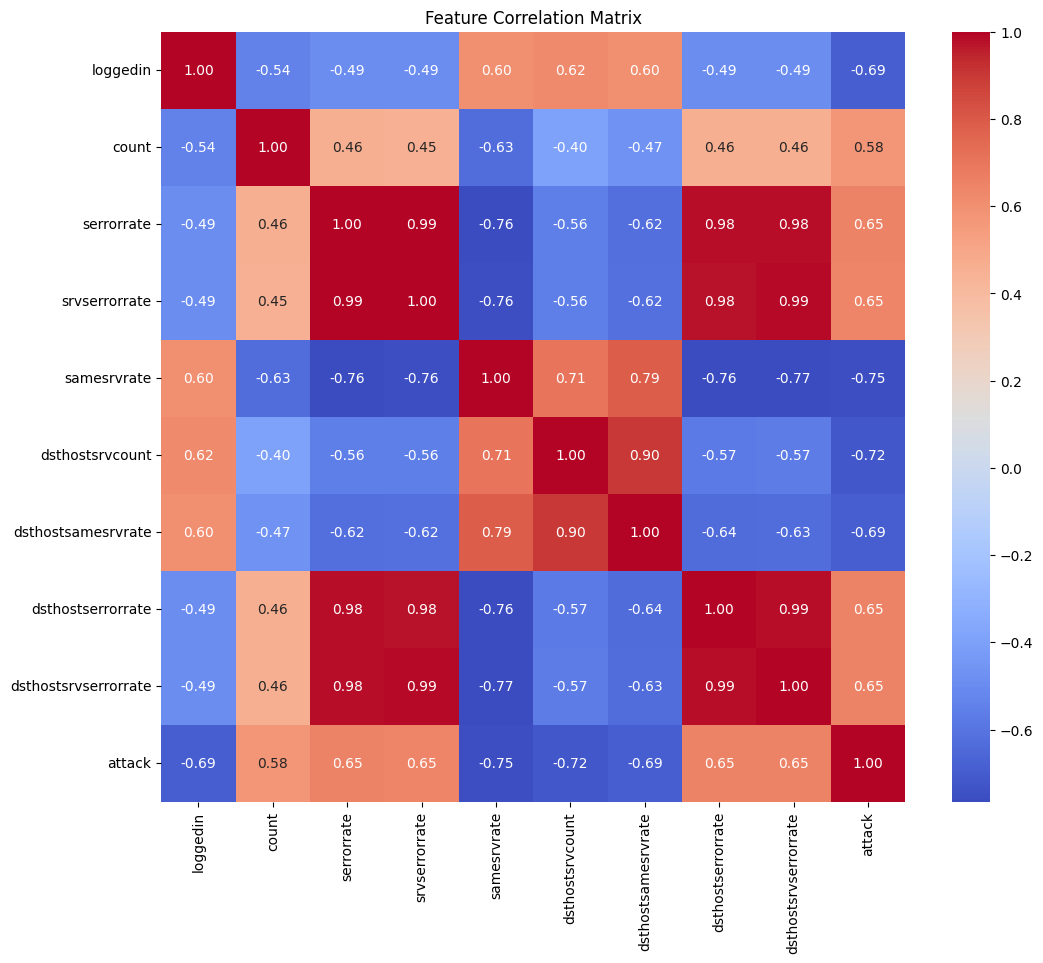

In [151]:
filtered_data = data[high_corr_features + [target_column]]




correlation_matrix = filtered_data.corr()



# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

In [152]:
X = data.drop('attack', axis=1)  
y = data['attack']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#pca = PCA(n_components=4)  
#X_pca = pca.fit_transform(X_scaled)


In [153]:
Y = data['attack']
X = data.drop(columns=['attack'])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [154]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

In [155]:
clf = LogisticRegression(class_weight='balanced', random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['normal', 'attack'], digits=4))

              precision    recall  f1-score   support

      normal     0.9780    0.9727    0.9753      6751
      attack     0.9687    0.9747    0.9717      5847

    accuracy                         0.9736     12598
   macro avg     0.9733    0.9737    0.9735     12598
weighted avg     0.9737    0.9736    0.9737     12598

